# Data Analysis of UKB Accelerometer Data

In this notebook, we will replicate [this research paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649). This was the paper that first introduced the Accelerometry variables available in the Showcase in UK Biobank, and is a good general introduction to the dataset. We briefly review a few key points here, but that paper is well worth a read!

There is one important difference between that paper and what we'll do here. Because we've already tidied our data to just work with the subset of participants without prior cardiovascular disease (as we'll use in the next notebook), we'll consider just that subset here as well. 

## UK Biobank accelerometry data: a very brief introduction 

**What is the UK Biobank accelerometer study?**

Between 2013 and 2015, approximately 100,000 UK Biobank participants wore a *physical activity monitor*. This *physical activity monitor* was an [Axivity AX3 research-grade accelerometer](https://axivity.com/product/ax3), and did not give feedback to participants. 

**Who participated in the UK Biobank accelerometer study?**

Roughly 100,000 participants from the original UK Biobank study. 

Recruitment (from [Doherty et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649)): 

> *Between February 2013 and December 2015, participants who had provided a valid email address were sent an email invitation to wear an accelerometer for seven days. The participant email addresses were chosen randomly, with the exception of the North West region which was excluded for much of the project due to participant burden concerns, as this area had been used to trial new projects. From June 2013, participants were sent devices in order of acceptance.*

**What is an accelerometer?**

An accelerometer is a device to measure acceleration. When the accelerometer is attached to the body (e.g. worn around the wrist as in UK Biobank), these acceleration measurements can be used to understand human movement.

Accelerometers are used in both research-grade and consumer activity monitors.  

**What was the measurement protocol in UK Biobank?** 

Please see [Doherty et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649).

Participants were posted an Axivity AX3 accelerometer to wear on the dominant wrist. It was set up to start at 10am two working days after postal dispatch, and to capture triaxial acceleration data over 7 days at 100 Hz with a dynamic range of +-8 *g*.

From [Doherty et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649): 

> *Participants were informed in the invitation email and device mail-out letter that the accelerometer should be worn continuously and that they should carry on with their normal activities. Participants were asked to start wearing the accelerometer immediately after receiving it in the post and to wear the monitor on their dominant wrist. They were also informed that the device was configured to automatically turn itself on soon after its arrival and off seven days later. Finally, participants were asked to mail the device back to the co-ordinating centre, in a pre-paid envelope, after the seven day monitoring period.*

**Did the device record other modalities?**
 
The device did not record other modalities which may be available in commercially-available devices (such as heart rate).

The device does record temperature and light, although to our knowledge these have not been directly used in health applications (temperature is used in device calibration).

**What can UK Biobank accelerometer data be used for?**

UK Biobank accelerometer data can be used to study many different phenotypes in conjunction with health and disease outcomes as well as with genetics:

- overall physical activity
- step count
- physical activity behaviours/ movement behaviours, including sleep, sedentary behaviour, light physical activity, moderate-to-vigorous physical activity, walking 
- behavioural pattern 
- energy expenditure
- circadian rhythm 
- sleep quality


**What phenotypes are available?**

Here we will consider only the original accelerometer-based phenotypes i.e. those that appeared in the initial [Doherty et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649) paper. These are available through the Data Showcase (standard tabular UK Biobank data). They include metrics relating to data quality (e.g. calibration and wear time), metrics of overall activity (average acceleration), metrics of time spent above different acceleration thresholds (which may be used for so-called 'cut-point' based definitions of time in different intensities of activity), and metrics by time of day/day of week. Basic properties of accelerometer wear, such as the date, are also recorded. Meanings of the different variables are extensively described both within Showcase and in the paper.

Since then, studies have developed different phenotypes and have applied their definitions to the UKB accelerometer data. Some of these phenotypes can now be accessed via 'returns' to the UK Biobank resources. For example: 

- machine-learning models have been developed to classify movement behaviours. See [[1](https://www.nature.com/articles/s41598-018-26174-1)]; [[2](https://www.nature.com/articles/s41467-018-07743-4)]; and [[3](https://bjsm.bmj.com/content/early/2022/08/02/bjsports-2021-104050), to be released soon].
- algorithms for [different sleep metrics](https://www.nature.com/articles/s41467-019-09576-1)

This probably only represents a small snapshot of what's been done. Let us know about other resources by adding an issue on GitHub or emailing us and we will add them to this list. 


**I'm interested in a different phenotype. Can I access the raw accelerometer files to generate it myself?** 

Yes. Bulk files for the accelerometer data are available via the RAP platform. You can also access 'intermediate' files, such as a [summarisation of the signal each 5 seconds](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=90004) (smaller in size than the raw data, which is a 100 Hz signal i.e. has 100 measurements/second).

You might also be interested in resources available to help process accelerometer data, such as: 

- https://github.com/OxWearables/biobankAccelerometerAnalysis
- https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html

Again, get in touch with additions to this list!



If you have other questions about the UKB accelerometer study, feel free to post them as an issue on GitHub. 

We'll now dive into having a look at the data. 

## About this notebook

This notebook is written in Python. 

If you prefer to work in R, there is nothing "Python-specific" here that could not easily be rewritten in R.

Most of the material in this notebook is due to Junayed Naushad.

## Set up the session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')

## Load data

In [2]:
dat = pd.read_csv("prepped_data.csv") # If running in the same session as the previous notebook
# dat = pd.read_csv("/mnt/project/users/Rosemary_Walmsley32/data/prepped_data.csv") # version if running in different session

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Following the paper that we're following here, we'll only analyse those participants aged 45 years and older:

In [3]:
print(dat.shape[0]) # print number of rows
dat = dat.loc[dat['age_entry_years'] >= 45]
print(dat.shape[0]) # print number of rows

88211
87973


You might note that there are slight differences in numbers relative to the published paper. We're using a different cohort, and it looks like we might have generated the age variable differently (different precision).

## Convert Fraction of Week to Hours

In [4]:
for col in dat.loc[:, 'Fraction acceleration <= 1 milli-gravities':'Fraction acceleration <= 300 milli-gravities'].columns:
    dat[col] = dat[col]*24*7

## Wear Duration

Looking at wear duration shows the majority of included participants have very high wear time:

In [5]:
wear_duration = dat['Wear duration overall'].to_numpy()
wear_percentiles = np.percentile(wear_duration, [25, 50, 75])
print('25th percentile wear duration: {:.3} days'.format(wear_percentiles[0]))
print('Median wear duration: {:.3} days'.format(wear_percentiles[1]))
print('75th percentile of wear duration: {:.3} days'.format(wear_percentiles[2]))

25th percentile wear duration: 6.69 days
Median wear duration: 6.92 days
75th percentile of wear duration: 7.0 days


## Acceleration by Age Group

In [6]:
first = dat.loc[(dat['age_entry_years'] >= 45) & (dat['age_entry_years'] < 55)]['overall_activity'].to_numpy()
second = dat.loc[(dat['age_entry_years'] >= 55) & (dat['age_entry_years'] < 65)]['overall_activity'].to_numpy()
third = dat.loc[(dat['age_entry_years'] >= 65) & (dat['age_entry_years'] < 75)]['overall_activity'].to_numpy()
fourth = dat.loc[(dat['age_entry_years'] >= 75) & (dat['age_entry_years'] < 80)]['overall_activity'].to_numpy()

age_groups = {
    '45-54 yrs': first,
    '55-64 yrs': second,
    '65-74 yrs': third,
    '75-79 yrs':fourth
}

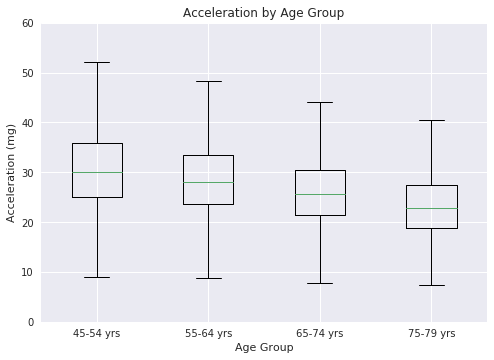

In [7]:
fig, ax = plt.subplots()
ax.boxplot(age_groups.values())
ax.set_xticklabels(age_groups.keys())
ax.set_ylabel('Acceleration (mg)')
ax.set_xlabel('Age Group')
ax.set_ylim(0, 60)
plt.title('Acceleration by Age Group')
plt.show()

## Acceleration by Sex

In [8]:
female_acc = dat.loc[dat['sex'] == 'Female']['overall_activity'].to_numpy()
male_acc = dat.loc[dat['sex'] == 'Male']['overall_activity'].to_numpy()

acc_sex = {
    'Female': female_acc,
    'Male': male_acc
}

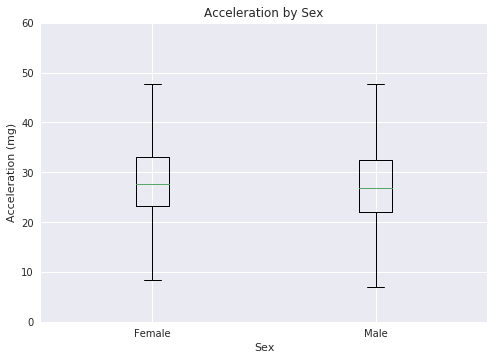

In [9]:
fig, ax = plt.subplots()
ax.boxplot(acc_sex.values())
ax.set_xticklabels(acc_sex.keys())
ax.set_ylabel('Acceleration (mg)')
ax.set_xlabel('Sex')
ax.set_ylim(0, 60)
plt.title('Acceleration by Sex')
plt.show()

## Acceleration by Age Group and Sex

In [10]:
dat_female = dat.loc[dat['sex'] == 'Female']
dat_male = dat.loc[dat['sex'] == 'Male']

first_female = dat_female.loc[(dat_female['age_entry_years'] >= 45) & (dat_female['age_entry_years'] < 55)]['overall_activity'].to_numpy()
second_female = dat_female.loc[(dat_female['age_entry_years'] >= 55) & (dat_female['age_entry_years'] < 65)]['overall_activity'].to_numpy()
third_female = dat_female.loc[(dat_female['age_entry_years'] >= 65) & (dat_female['age_entry_years'] < 75)]['overall_activity'].to_numpy()
fourth_female = dat_female.loc[(dat_female['age_entry_years'] >= 75) & (dat_female['age_entry_years'] < 80)]['overall_activity'].to_numpy()

first_male = dat_male.loc[(dat_male['age_entry_years'] >= 45) & (dat_male['age_entry_years'] < 55)]['overall_activity'].to_numpy()
second_male = dat_male.loc[(dat_male['age_entry_years'] >= 55) & (dat_male['age_entry_years'] < 65)]['overall_activity'].to_numpy()
third_male = dat_male.loc[(dat_male['age_entry_years'] >= 65) & (dat_male['age_entry_years'] < 75)]['overall_activity'].to_numpy()
fourth_male = dat_male.loc[(dat_male['age_entry_years'] >= 75) & (dat_male['age_entry_years'] < 80)]['overall_activity'].to_numpy()

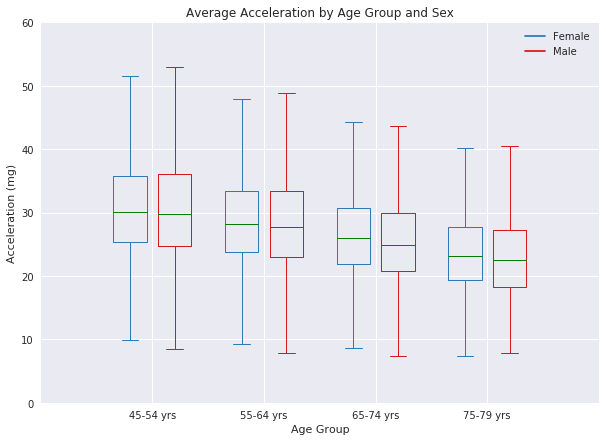

In [11]:
female = [first_female, second_female, third_female, fourth_female]
male = [first_male, second_male, third_male, fourth_male]

ticks = ['45-54 yrs', '55-64 yrs', '65-74 yrs', '75-79 yrs']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='green')
    
plt.figure(figsize=(10,7))

bp_female = plt.boxplot(female, positions=np.array(range(len(female)))*2.0 - 0.4, sym='', widths=0.6)
bp_male = plt.boxplot(male, positions=np.array(range(len(male)))*2.0 + 0.4, sym='', widths=0.6)
set_box_color(bp_female, '#2C7BB6')
set_box_color(bp_male, '#D7191C')

plt.plot([], c='#2C7BB6', label='Female')
plt.plot([], c='#D7191C', label='Male')
plt.legend()

plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 60)
plt.xlabel('Age Group')
plt.ylabel('Acceleration (mg)')
plt.title('Average Acceleration by Age Group and Sex')
plt.show()

## Acceleration by Day

In [12]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
acc_by_day = {}
for day in days:
    acc_by_day[day] = dat[day + ' average acceleration'].to_numpy()

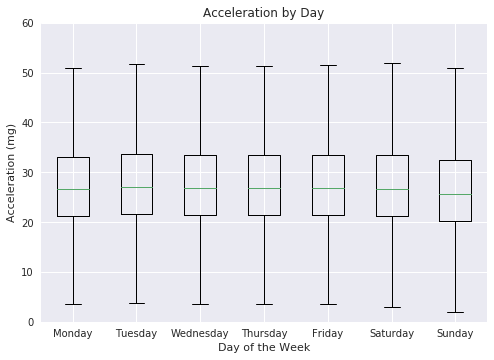

In [13]:
fig, ax = plt.subplots()
ax.boxplot(acc_by_day.values())
ax.set_xticklabels(acc_by_day.keys())
ax.set_ylabel('Acceleration (mg)')
ax.set_xlabel('Day of the Week')
ax.set_ylim(0, 60)
plt.title('Acceleration by Day')
plt.show()

## Acceleration Weekday/Weekend

In [14]:
weekdays = np.zeros(len(dat))
for day in days[:5]:
    weekdays += acc_by_day[day]
weekdays /= 5

weekends = np.zeros(len(dat))
for day in days[5:]:
    weekends += acc_by_day[day]
weekends /= 2

week_vs_weekend = {'Weekday': weekdays, 'Weekend': weekends}

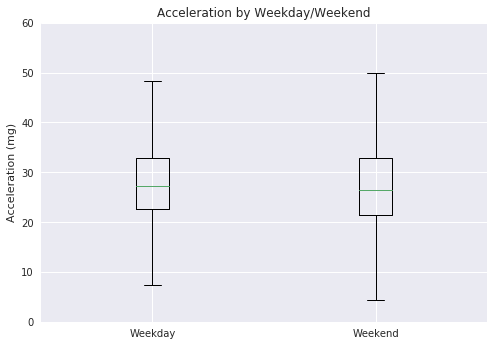

In [15]:
fig, ax = plt.subplots()
ax.boxplot(week_vs_weekend.values())
ax.set_xticklabels(week_vs_weekend.keys())
ax.set_ylabel('Acceleration (mg)')
ax.set_ylim(0,60)
plt.title('Acceleration by Weekday/Weekend')
plt.show()

## Acceleration by Season

We add a season column:

In [16]:
dat['end_month'] = pd.DatetimeIndex(dat['date_end_accel']).month
dat['Season'] = None
dat.loc[dat['end_month'].isin([12, 1, 2]),'Season'] = 'Winter'
dat.loc[dat['end_month'].isin([3, 4, 5]),'Season'] = 'Spring'
dat.loc[dat['end_month'].isin([6, 7, 8]),'Season'] = 'Summer'
dat.loc[dat['end_month'].isin([9, 10, 11]),'Season'] = 'Fall'

In [17]:
winter_acc = dat.loc[dat['Season'] == 'Winter']['overall_activity'].to_numpy()
spring_acc = dat.loc[dat['Season'] == 'Spring']['overall_activity'].to_numpy()
summer_acc = dat.loc[dat['Season'] == 'Summer']['overall_activity'].to_numpy()
fall_acc = dat.loc[dat['Season'] == 'Fall']['overall_activity'].to_numpy()

acc_by_season = {
    'Winter': winter_acc,
    'Spring': spring_acc,
    'Summer': summer_acc,
    'Fall': fall_acc
}

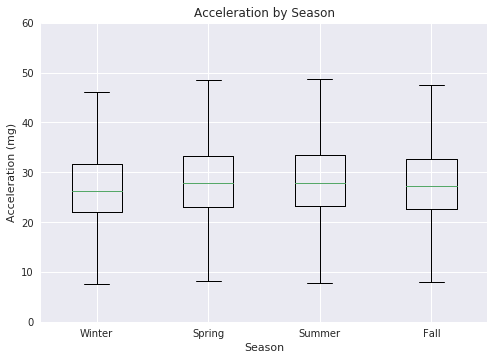

In [18]:
fig, ax = plt.subplots()
ax.boxplot(acc_by_season.values())
ax.set_xticklabels(acc_by_season.keys())
ax.set_ylabel('Acceleration (mg)')
ax.set_xlabel('Season')
ax.set_ylim(0,60)
plt.title('Acceleration by Season')
plt.show()

## Acceleration by Time of Day

In [19]:
# set up tick marks
hour = ['12am'] + [str(i)+'am' for i in range(1,12)] + ['12pm'] + [str(i)+'pm' for i in range(1,12)]

# get women split by age group
dat_first_female = dat_female.loc[(dat_female['age_entry_years'] >= 45) & (dat_female['age_entry_years'] < 55)]
dat_second_female = dat_female.loc[(dat_female['age_entry_years'] >= 55) & (dat_female['age_entry_years'] < 65)]
dat_third_female = dat_female.loc[(dat_female['age_entry_years'] >= 65) & (dat_female['age_entry_years'] < 75)]
dat_fourth_female = dat_female.loc[(dat_female['age_entry_years'] >= 75) & (dat_female['age_entry_years'] < 80)]

# calculate average acceleration in each group by hour of day
mean_acc_first_female = dat_first_female.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_second_female = dat_second_female.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_third_female = dat_third_female.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_fourth_female = dat_fourth_female.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()

# get men split by age group
dat_first_male = dat_male.loc[(dat_male['age_entry_years'] >= 45) & (dat_male['age_entry_years'] < 55)]
dat_second_male = dat_male.loc[(dat_male['age_entry_years'] >= 55) & (dat_male['age_entry_years'] < 65)]
dat_third_male = dat_male.loc[(dat_male['age_entry_years'] >= 65) & (dat_male['age_entry_years'] < 75)]
dat_fourth_male = dat_male.loc[(dat_male['age_entry_years'] >= 75) & (dat_male['age_entry_years'] < 80)]

# calculate average acceleration in each group by hour of day
mean_acc_first_male = dat_first_male.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_second_male = dat_second_male.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_third_male = dat_third_male.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()
mean_acc_fourth_male = dat_fourth_male.loc[:, 'Average acceleration 00:00 - 00:59':'Average acceleration 23:00 - 23:59'].mean(axis=0).to_numpy()

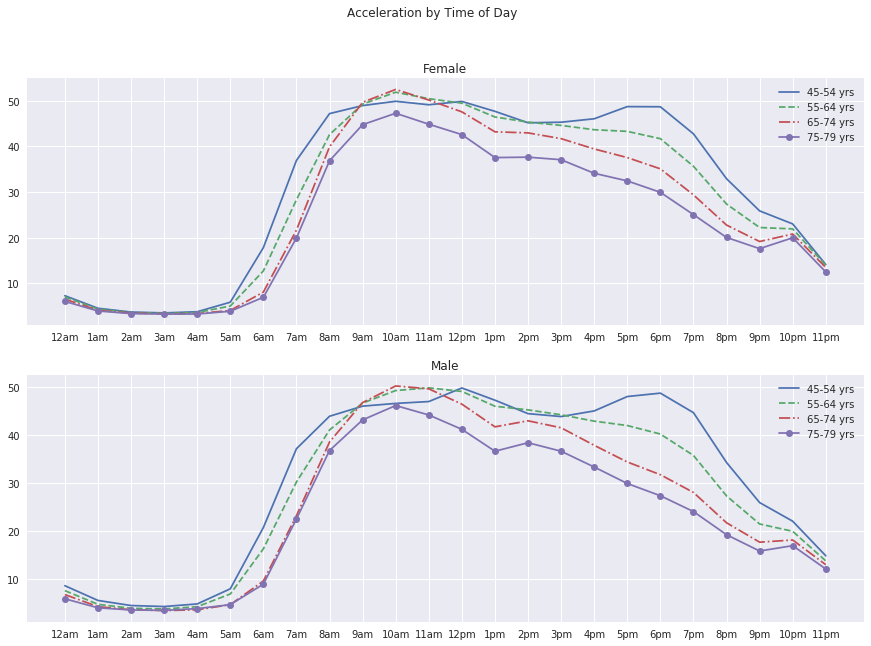

In [20]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].plot(hour, mean_acc_first_female, '-', label='45-54 yrs')
ax[0].plot(hour, mean_acc_second_female, '--', label='55-64 yrs')
ax[0].plot(hour, mean_acc_third_female, '-.', label='65-74 yrs')
ax[0].plot(hour, mean_acc_fourth_female, '-o', label='75-79 yrs')
ax[0].legend()
ax[0].set_title('Female')

ax[1].plot(hour, mean_acc_first_male, '-', label='45-54 yrs')
ax[1].plot(hour, mean_acc_second_male, '--', label='55-64 yrs')
ax[1].plot(hour, mean_acc_third_male, '-.', label='65-74 yrs')
ax[1].plot(hour, mean_acc_fourth_male, '-o', label='75-79 yrs')
ax[1].legend()
ax[1].set_title('Male')

fig.suptitle('Acceleration by Time of Day')
plt.show()

## Cumulative time spent at acceleration levels below certain values by sex and age

We'll look at cumulative time spent up to particular acceleration values, split by sex and age. As the acceleration range spanned is large, we'll make two cumulative plots, with different levels of granularity. This allows us to see both the detail at the lower end and the big picture. So we can easily repeat across groups, we'll write some functions to make the plots:

In [21]:
def get_plot_cols(dat_female, dat_male, plotvals):
    # Restrict to columns we care about
    dat_female_acc_dist = dat_female.loc[:, 'Fraction acceleration <= 1 milli-gravities':'Fraction acceleration <= 2000 milli-gravities']
    dat_male_acc_dist = dat_male.loc[:, 'Fraction acceleration <= 1 milli-gravities':'Fraction acceleration <= 2000 milli-gravities']
    
    # Get positions for all columns 
    colpositionsgravs = [re.sub('Fraction acceleration <= ', '', x) for x in dat_female_acc_dist.columns]
    colpositions = np.array([re.sub(' milli-gravities', '', x) for x in colpositionsgravs]).astype('int')
    
    # Get columns associated with values we want
    female = []
    male = []
    for col in dat_female_acc_dist.columns[np.isin(colpositions, plotvals)]:
        female.append(dat_female_acc_dist[col].to_numpy())
        male.append(dat_male_acc_dist[col].to_numpy())
    
    # Return arrays
    return(female, male)

def plot_cumulative_acc(dat_female, dat_male, title):
    # Set up data for the first plot: cumulative acceleration up to 10 mg
    below_ten = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    female_ten, male_ten = get_plot_cols(dat_female, dat_male, below_ten)
    diff_ten = below_ten[1] - below_ten[0] # This is just the interval width
    
    # Set up data for the second plot: cumulative acceleration from 25 mg to 300 mg 
    to_300 = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300])
    female_300, male_300 = get_plot_cols(dat_female, dat_male, to_300)
    diff_300 = to_300[1] - to_300[0] # This is just the interval width
    
    # Create first plot
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15, 7))
    fig.suptitle(title)
    bp_female = ax1.boxplot(female_ten, positions= below_ten - 0.1*diff_ten, sym='', widths= 0.1*diff_ten)
    bp_male = ax1.boxplot(male_ten, positions= below_ten + 0.1*diff_ten, sym='', widths=0.1*diff_ten)
    set_box_color(bp_female, '#2C7BB6')
    set_box_color(bp_male, '#D7191C')
    ax1.plot([], c='#2C7BB6', label='Female')
    ax1.plot([], c='#D7191C', label='Male')
    ax1.set_xticks(below_ten)
    ax1.set_xticklabels(below_ten)
    ax1.set_xlim(0, max(below_ten) + diff_ten)
    ax1.set_ylim(0, 168)
    ax1.set_xlabel('Acceleration level (mg)')
    ax1.set_ylabel('Cumulative time (hours / week)')
    
    # Create second plot
    bp_female2 = ax2.boxplot(female_300, positions= to_300 - 0.1*diff_300, sym='', widths= 0.1*diff_300)
    bp_male2 = ax2.boxplot(male_300, positions= to_300 + 0.1*diff_300, sym='', widths=0.1*diff_300)
    set_box_color(bp_female2, '#2C7BB6')
    set_box_color(bp_male2, '#D7191C')
    ax2.plot([], c='#2C7BB6', label='Female')
    ax2.plot([], c='#D7191C', label='Male')
    ax2.legend()
    ax2.set_xticks(to_300)
    ax2.set_xticklabels(to_300)
    ax2.set_xlim(0, max(to_300) + diff_300)
    ax2.set_ylim(0, 180)
    ax2.set_xlabel('Acceleration level (mg)')
    ax2.set_ylabel('Cumulative time (hours / week)')
    
    # Show figure
    fig.show()

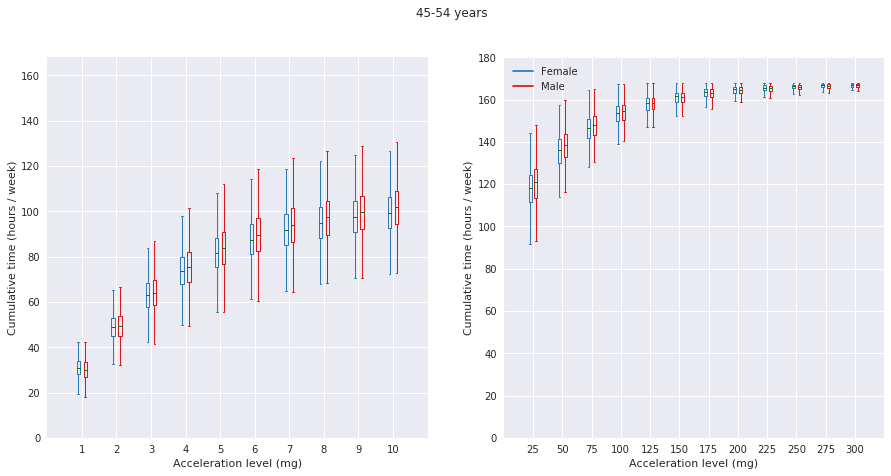

In [22]:
plot_cumulative_acc(dat_first_female, dat_first_male, '45-54 years')

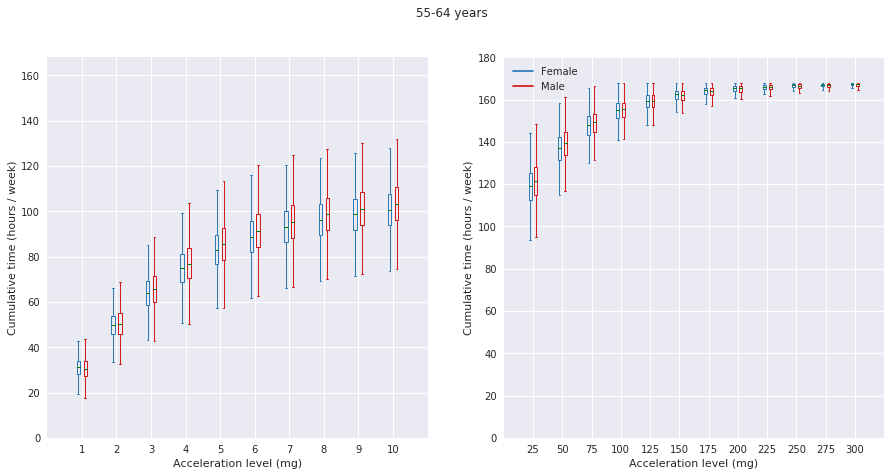

In [23]:
plot_cumulative_acc(dat_second_female, dat_second_male, '55-64 years')

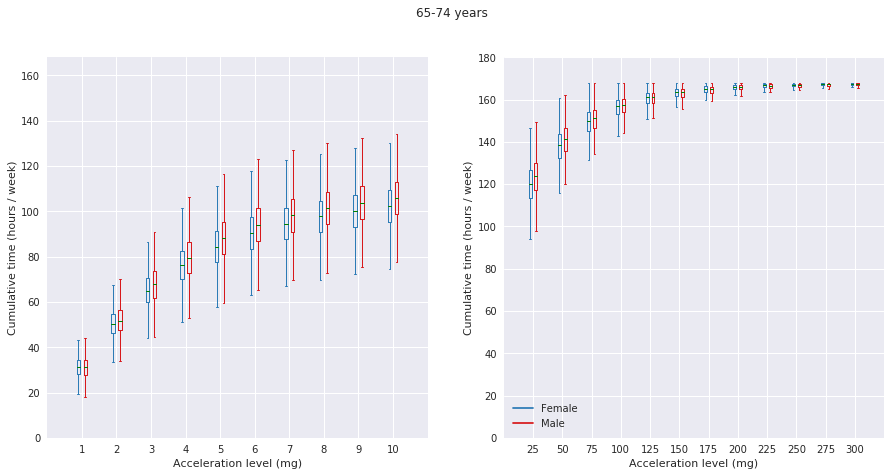

In [24]:
plot_cumulative_acc(dat_third_female, dat_third_male, '65-74 years')

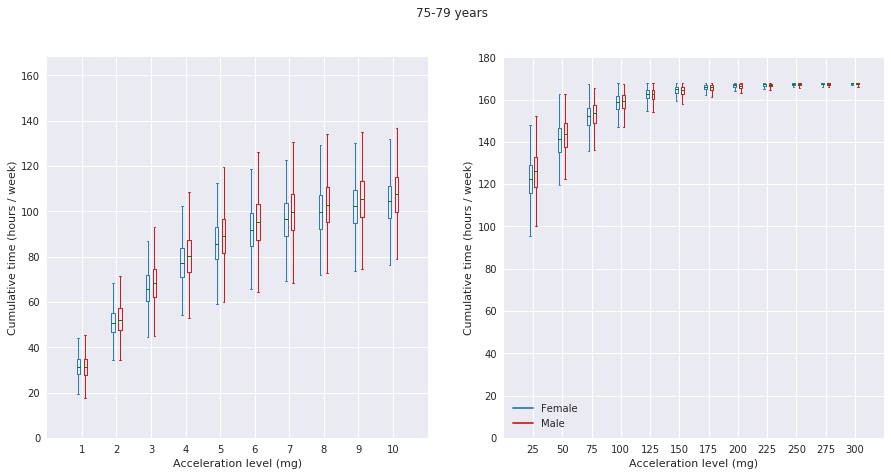

In [25]:
plot_cumulative_acc(dat_fourth_female, dat_fourth_male, '75-79 years')